### Does Systematic Fundamental Investing Work in Brazil?

**Dataset Construction Script**

This notebook builds a monthly panel dataset of Brazilian listed equities by:
1. Pulling annual fundamentals from Compustat Global (WRDS)
2. Pulling monthly return/price data from Datastream (WRDS), restricted to firms covered by Compustat via the `comp.g_security` bridge table
3. Merging via ISIN with point-in-time alignment (6-month lag for annual data)
4. Computing 24 fundamental characteristics + 9 market-scaled characteristics
5. Saving the final panel as `data/brazil_fundamental_panel.parquet`

In [2]:
"""
Builds a monthly panel dataset of Brazilian listed equities from WRDS
(Compustat Global + Datastream).

Author: Julia Borges Notarangeli
"""

# Standard Libraries
import os
import warnings
from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd
import wrds
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# ═══════════════════════════════════════════════════════════════════════
# 0.  PARAMETERS
# ═══════════════════════════════════════════════════════════════════════
START_DATE = "2000-01-01"
END_DATE   = "2025-12-31"
OUTPUT_DIR = Path("data")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

ANNUAL_LAG_MONTHS    = 6   # point-in-time lag for annual fundamentals
QUARTERLY_LAG_MONTHS = 3   # (reserved – not used in this version)

# ═══════════════════════════════════════════════════════════════════════
# 1.  WRDS CONNECTION
# ═══════════════════════════════════════════════════════════════════════
print("Connecting to WRDS …")
db = wrds.Connection()                       # uses ~/.pgpass or prompts
print("Connected ✓")


# ═══════════════════════════════════════════════════════════════════════
# 2.  PULL COMPUSTAT GLOBAL – ANNUAL FUNDAMENTALS
# ═══════════════════════════════════════════════════════════════════════
def pull_compustat_annual(db, start: str, end: str) -> pd.DataFrame:
    """
    Pull annual fundamentals for Brazilian firms from comp.g_funda.
    
    WRDS schema notes (Compustat Global vs. North America):
      - Schema is 'comp', table is 'g_funda'
      - No 'ni' column → use 'ib' (income before extraordinary items)
        and 'nicon' as fallback
      - No 'csho' → use 'cshoi' (common shares outstanding, issue-level)
      - No 'gp' → compute as sale − cogs
      - No 'pstkrv'/'pstkl'/'itcb'/'ipodate' → use 'pstkr' for pref stock
        redemption; skip the rest
    """
    query = f"""
    SELECT
        a.gvkey,
        a.datadate,
        a.fyear,
        a.fyr,                      -- fiscal-year-end month
        a.isin,
        a.conm,                     -- company name
        a.curcd,                    -- currency code

        /* ── Size / Balance-sheet ───────────────────────────── */
        a.at,                       -- total assets
        a.lt,                       -- total liabilities
        a.seq,                      -- stockholders' equity
        a.ceq,                      -- common equity (book)
        a.txdb,                     -- deferred taxes (balance-sheet)
        a.pstk,                     -- pref stock – carrying value
        a.pstkr,                    -- pref stock – redemption value

        /* ── Income-statement / cash-flow ───────────────────── */
        a.sale,                     -- net sales
        a.revt,                     -- total revenue
        a.cogs,                     -- cost of goods sold
        a.ebit,                     -- EBIT
        a.ebitda,                   -- EBITDA
        a.ib,                       -- income before extraordinary items
        a.nicon,                    -- net income (consolidated)
        a.oancf,                    -- operating CF (cash-flow stmt)
        a.dp,                       -- depreciation & amortisation
        a.xint,                     -- interest expense
        a.xsga,                     -- SGA expense
        a.xrd,                      -- R&D expense
        a.capx,                     -- capital expenditures
        a.txt,                      -- income taxes total
        a.dvt,                      -- total dividends (cash)
        a.dvc,                      -- dividends – common

        /* ── Working capital items ──────────────────────────── */
        a.act,                      -- current assets
        a.lct,                      -- current liabilities
        a.che,                      -- cash & short-term investments
        a.invt,                     -- inventories
        a.rect,                     -- receivables
        a.ap,                       -- accounts payable
        a.dlc,                      -- debt in current liabilities
        a.dltt,                     -- long-term debt

        /* ── Other ──────────────────────────────────────────── */
        a.ppent,                    -- PP&E net
        a.ppegt,                    -- PP&E gross
        a.emp,                      -- number of employees
        a.wcap,                     -- working capital
        a.re,                       -- retained earnings

        /* ── Shares ─────────────────────────────────────────── */
        a.cshoi                     -- common shares outstanding (issue)

    FROM comp.g_funda AS a

    WHERE a.loc      = 'BRA'                  -- Brazil
      AND a.indfmt   = 'INDL'                 -- industrial format
      AND a.datafmt  = 'HIST_STD'             -- historical-standardised
      AND a.consol   = 'C'                    -- consolidated
      AND a.popsrc   = 'I'                    -- international
      AND a.datadate BETWEEN '{start}' AND '{end}'

    ORDER BY a.gvkey, a.datadate
    """
    print("Downloading Compustat Global annual fundamentals …")
    df = db.raw_sql(query, date_cols=["datadate"])
    print(f"  → {len(df):,} firm-year rows, {df['gvkey'].nunique()} unique gvkeys")

    # ── Create unified columns ──────────────────────────────────────────
    # ni: use ib, fall back to nicon
    df["ni"] = df["ib"].fillna(df["nicon"])
    # csho: rename cshoi
    df["csho"] = df["cshoi"]
    # gp: compute from sale − cogs
    df["gp"] = df["sale"] - df["cogs"]

    return df


# ═══════════════════════════════════════════════════════════════════════
# 3.  PULL DATASTREAM – MONTHLY PRICES & RETURNS
# ═══════════════════════════════════════════════════════════════════════
def pull_datastream_monthly(db, start: str, end: str) -> pd.DataFrame:
    """
    Pull monthly total-return index (RI), price, market cap, and shares
    outstanding for Brazilian equities from WRDS Datastream.

    WRDS schema notes:
      - Names table:  tr_ds_equities.wrds_ds_names
        • 'ismajorsec' (not 'ismajsec')
        • 'cmpyctrycode' for country, 'isin' for ISIN
      - Daily data:   tr_ds_equities.wrds_ds2dsf
        • Columns: infocode, marketdate, close, ri, mktcap, numshrs
        • No pre-built monthly table → filter to last trading day per month

    We restrict to ISINs that appear in comp.g_security so the panel
    only includes firms covered by Compustat Global.
    """
    # ── Step 0: build ISIN whitelist from comp.g_security ───────────────
    # g_security has many more ISINs than g_funda (covers all share
    # classes).  We keep only ISINs whose gvkey also appears in g_funda
    # (i.e., the firm actually has fundamental data).
    print("Building Compustat ISIN whitelist via comp.g_security …")
    sec_bridge = db.raw_sql("""
        SELECT DISTINCT s.isin, s.gvkey
        FROM comp.g_security AS s
        WHERE s.isin LIKE 'BR%%'
    """)
    # Keep only gvkeys that have at least one row in g_funda
    funda_gvkeys = db.raw_sql(f"""
        SELECT DISTINCT gvkey
        FROM comp.g_funda
        WHERE loc = 'BRA'
          AND indfmt = 'INDL' AND datafmt = 'HIST_STD'
          AND consol = 'C' AND popsrc = 'I'
          AND datadate BETWEEN '{start}' AND '{end}'
    """)["gvkey"].unique()
    sec_bridge = sec_bridge[sec_bridge["gvkey"].isin(funda_gvkeys)]
    compustat_isins = set(sec_bridge["isin"].dropna().unique())
    print(f"  → {len(compustat_isins):,} ISINs linked to {len(set(sec_bridge['gvkey'])):,} Compustat gvkeys")

    # ── Step A: identify Brazilian ISINs ────────────────────────────────
    info_query = """
    SELECT DISTINCT
        d.infocode,
        d.dscode,
        d.isin,
        d.dssecname   AS name,
        d.cmpyctrycode,
        d.ismajorsec,
        d.isprimqt
    FROM tr_ds_equities.wrds_ds_names AS d
    WHERE d.isin LIKE 'BR%%'
      AND d.cmpyctrycode = 'BR'
    """
    print("Downloading Datastream security info for Brazil …")
    info = db.raw_sql(info_query)
    print(f"  → {len(info):,} Brazilian Datastream securities")

    # Keep only major securities (primary share class)
    if "ismajorsec" in info.columns:
        primary = info[info["ismajorsec"] == "Y"]
        if len(primary) > 0:
            info = primary
        print(f"  → {len(info):,} after major-security filter")

    # ── Filter to Compustat-covered ISINs only ──────────────────────────
    info = info[info["isin"].isin(compustat_isins)]
    print(f"  → {len(info):,} after restricting to Compustat-covered ISINs")

    infocodes = info["infocode"].dropna().unique().tolist()
    if len(infocodes) == 0:
        raise ValueError("No Brazilian infocodes found in Datastream names table.")

    # ── Step B: pull daily data in batches, keep month-end only ─────────
    # Strategy: pull from wrds_ds2dsf but restrict to last business day
    # of each month using a SQL window function.
    batch_size = 200
    dfs = []
    for i in range(0, len(infocodes), batch_size):
        batch = infocodes[i : i + batch_size]
        codes_str = ",".join([str(int(c)) for c in batch])
        ts_query = f"""
        WITH ranked AS (
            SELECT
                t.infocode,
                t.marketdate,
                t.ri,                         -- total return index
                t.close       AS price,       -- closing price
                t.mktcap,                     -- market capitalisation
                t.numshrs,                    -- number of shares
                ROW_NUMBER() OVER (
                    PARTITION BY t.infocode,
                                DATE_TRUNC('month', t.marketdate)
                    ORDER BY t.marketdate DESC
                ) AS rn
            FROM tr_ds_equities.wrds_ds2dsf AS t
            WHERE t.infocode IN ({codes_str})
              AND t.marketdate BETWEEN '{start}' AND '{end}'
        )
        SELECT infocode, marketdate, ri, price, mktcap, numshrs
        FROM ranked
        WHERE rn = 1
        ORDER BY infocode, marketdate
        """
        chunk = db.raw_sql(ts_query, date_cols=["marketdate"])
        dfs.append(chunk)
        print(f"  batch {i // batch_size + 1}: {len(chunk):,} rows")

    ts = pd.concat(dfs, ignore_index=True)
    print(f"  → Total Datastream monthly rows: {len(ts):,}")

    # Merge back ISIN and name
    ts = ts.merge(info[["infocode", "isin", "name"]], on="infocode", how="left")
    return ts


# ═══════════════════════════════════════════════════════════════════════
# 4.  HELPER:  COMPUTE BOOK EQUITY
# ═══════════════════════════════════════════════════════════════════════
def compute_book_equity(df: pd.DataFrame) -> pd.Series:
    """
    Book equity (BE) = stockholders' equity
                     + deferred taxes (balance-sheet)
                     − preferred stock

    Preferred stock hierarchy:  pstkr → pstk → 0
    Stockholders' equity hierarchy:  seq → ceq + pstk → at − lt
    
    Note: Compustat Global does not have pstkrv / pstkl / itcb.
    """
    # Preferred stock (use best available)
    ps = df["pstkr"].copy()
    ps = ps.fillna(df["pstk"])
    ps = ps.fillna(0)

    # Stockholders' equity
    se = df["seq"].copy()
    mask = se.isna()
    se.loc[mask] = df.loc[mask, "ceq"].add(
        df.loc[mask, "pstk"].fillna(0), fill_value=0
    )
    mask = se.isna()
    se.loc[mask] = df.loc[mask, "at"].sub(df.loc[mask, "lt"], fill_value=0)

    be = se + df["txdb"].fillna(0) - ps
    be[be <= 0] = np.nan          # negative BE → missing
    return be


# ═══════════════════════════════════════════════════════════════════════
# 5.  HELPER:  COMPUTE MARKET EQUITY  (from Datastream)
# ═══════════════════════════════════════════════════════════════════════
def compute_market_equity(ds: pd.DataFrame) -> pd.DataFrame:
    """
    market_equity = mktcap  (Datastream reports in local currency)

    If mktcap is missing, fall back to  price * numshrs.

    Also compute monthly return from the total-return index:
        ret = RI_t / RI_{t-1} − 1
    """
    ds = ds.sort_values(["isin", "marketdate"]).copy()

    # Market equity
    ds["market_equity"] = ds["mktcap"]
    fallback = ds["price"] * ds["numshrs"]
    ds["market_equity"] = ds["market_equity"].fillna(fallback)
    ds.loc[ds["market_equity"] <= 0, "market_equity"] = np.nan

    # Monthly return from total-return index
    ds["ri_lag"] = ds.groupby("isin")["ri"].shift(1)
    ds["ret"] = ds["ri"] / ds["ri_lag"] - 1
    ds.loc[ds["ri_lag"].isna() | (ds["ri_lag"] <= 0), "ret"] = np.nan

    return ds


# ═══════════════════════════════════════════════════════════════════════
# 6.  HELPER:  BUILD ANNUAL ACCOUNTING CHARACTERISTICS
# ═══════════════════════════════════════════════════════════════════════
def build_annual_chars(comp: pd.DataFrame) -> pd.DataFrame:
    """
    Compute the 24 fundamental (accounting-only) characteristics from
    Compustat Global annual data.  Returns one row per gvkey-datadate.
    
    ── DATA DICTIONARY ──────────────────────────────────────────────────
    Characteristic        Formula
    ─────────────────────────────────────────────────────────────────────
    age                   Years since first Compustat appearance
    at_gr1                (AT_t / AT_{t-1}) − 1
    be_gr1a               (BE_t / BE_{t-1}) − 1
    capx_gr1              (CAPX_t / CAPX_{t-1}) − 1
    cash_at               CHE / AT
    debt_gr3              (DLTT+DLC)_t / (DLTT+DLC)_{t-3} − 1
    ebit_sale             EBIT / SALE
    emp_gr1               (EMP_t / EMP_{t-1}) − 1
    f_score               Piotroski F-Score (0–9)
    gp_at                 (SALE − COGS) / AT
    inv_gr1               (INVT_t / INVT_{t-1}) − 1
    kz_index              Kaplan-Zingales index
    netis_at              Δlog(CSHO) / AT
    ni_be                 NI / BE  (return on equity)
    noa_at                (OA − OL) / AT
    o_score               Ohlson O-Score
    oaccruals_at          (Δ(CA−Cash) − Δ(CL−STD) − DP) / AT
    ocf_at                OANCF / AT
    op_at                 (GP − XSGA + XRD) / AT
    rd_sale               XRD / SALE
    sale_gr1              (SALE_t / SALE_{t-1}) − 1
    taccruals_at          (IB − OANCF) / AT
    tangibility           PPENT / AT
    z_score               Altman Z-Score
    ─────────────────────────────────────────────────────────────────────
    """
    c = comp.copy()

    # ── Book equity ─────────────────────────────────────────────────────
    c["be"] = compute_book_equity(c)

    # ── Gross profit (fill if missing) ──────────────────────────────────
    c["gp_calc"] = c["gp"].fillna(c["sale"].sub(c["cogs"], fill_value=0))

    # ── Total debt ──────────────────────────────────────────────────────
    c["debt"] = c["dltt"].fillna(0) + c["dlc"].fillna(0)

    # ── Lagged values (1-year and 3-year) ──────────────────────────────
    c = c.sort_values(["gvkey", "datadate"])
    for col in ["at", "be", "sale", "capx", "invt", "emp", "debt", "csho"]:
        c[f"{col}_lag1"] = c.groupby("gvkey")[col].shift(1)
    c["debt_lag3"] = c.groupby("gvkey")["debt"].shift(3)

    # ── First appearance (for age) ──────────────────────────────────────
    first_year = c.groupby("gvkey")["datadate"].transform("min")
    c["age"] = ((c["datadate"] - first_year).dt.days / 365.25).round(0)

    # ── Growth rates (1-year) ───────────────────────────────────────────
    def safe_growth(num, denom):
        """(num / denom) − 1, with denom ≤ 0 → NaN."""
        denom = denom.copy()
        denom[denom <= 0] = np.nan
        return num / denom - 1

    c["at_gr1"]   = safe_growth(c["at"],   c["at_lag1"])
    c["be_gr1a"]  = safe_growth(c["be"],   c["be_lag1"])
    c["capx_gr1"] = safe_growth(c["capx"], c["capx_lag1"])
    c["sale_gr1"] = safe_growth(c["sale"], c["sale_lag1"])
    c["inv_gr1"]  = safe_growth(c["invt"], c["invt_lag1"])
    c["emp_gr1"]  = safe_growth(c["emp"],  c["emp_lag1"])

    # ── 3-year debt growth ──────────────────────────────────────────────
    debt_lag3 = c["debt_lag3"].copy()
    debt_lag3[debt_lag3 <= 0] = np.nan
    c["debt_gr3"] = c["debt"] / debt_lag3 - 1

    # ── Profitability / margin ratios ───────────────────────────────────
    c["cash_at"]    = c["che"] / c["at"]
    c["gp_at"]      = c["gp_calc"] / c["at"]
    c["ebit_sale"]  = c["ebit"] / c["sale"].replace(0, np.nan)
    c["ni_be"]      = c["ni"] / c["be"]
    c["ocf_at"]     = c["oancf"] / c["at"]
    c["rd_sale"]    = c["xrd"] / c["sale"].replace(0, np.nan)
    c["tangibility"] = c["ppent"] / c["at"]

    # ── Operating profitability / AT  (Novy-Marx style) ────────────────
    op_num = (c["gp_calc"].fillna(0)
              - c["xsga"].fillna(0)
              + c["xrd"].fillna(0))
    c["op_at"] = op_num / c["at"]

    # ── Accruals ────────────────────────────────────────────────────────
    # Total accruals  = IB − OANCF
    c["taccruals_at"] = (c["ib"] - c["oancf"].fillna(0)) / c["at"]

    # Operating accruals (balance-sheet approach)
    #   = Δ(CA − Cash) − Δ(CL − STD) − DP
    ca_net = c["act"] - c["che"]
    cl_net = c["lct"] - c["dlc"].fillna(0)
    ca_net_lag = c.groupby("gvkey")["act"].shift(1) - c.groupby("gvkey")["che"].shift(1)
    cl_net_lag = c.groupby("gvkey")["lct"].shift(1) - c.groupby("gvkey")["dlc"].shift(1).fillna(0)
    delta_ca = ca_net - ca_net_lag
    delta_cl = cl_net - cl_net_lag
    c["oaccruals_at"] = (delta_ca - delta_cl - c["dp"].fillna(0)) / c["at"]

    # ── Net operating assets / AT ───────────────────────────────────────
    oa = c["at"] - c["che"].fillna(0)
    ol = (c["at"]
          - c["dltt"].fillna(0)
          - c["dlc"].fillna(0)
          - c["ceq"].fillna(0)
          - c["pstk"].fillna(0))
    c["noa_at"] = (oa - ol) / c["at"]

    # ── Net stock issuance / AT ─────────────────────────────────────────
    c["log_csho"] = np.log(c["csho"].replace(0, np.nan))
    c["log_csho_lag1"] = c.groupby("gvkey")["log_csho"].shift(1)
    c["netis_at"] = (c["log_csho"] - c["log_csho_lag1"])
    c["netis_at"] = c["netis_at"] / c["at"].replace(0, np.nan)

    # ── Piotroski F-Score (0–9) ─────────────────────────────────────────
    # Note: use .astype(float) instead of .astype(int) to handle NA values
    #       from the database (nullable dtypes can't cast NA → int).
    f = pd.DataFrame(index=c.index)
    f["f1"] = (c["ni"] > 0).astype(float)
    f["f2"] = (c["oancf"] > 0).astype(float)
    f["f3"] = ((c["ni"] / c["at"]) > (
        c.groupby("gvkey")["ni"].shift(1) / c["at_lag1"]
    )).astype(float)
    f["f4"] = (c["oancf"] > c["ni"]).astype(float)
    # Leverage change
    f["f5"] = ((c["debt"] / c["at"]) < (
        c.groupby("gvkey")["debt"].shift(1) / c["at_lag1"]
    )).astype(float)
    # Current ratio change
    c["cr"] = c["act"] / c["lct"].replace(0, np.nan)
    c["cr_lag1"] = c.groupby("gvkey")["cr"].shift(1)
    f["f6"] = (c["cr"] > c["cr_lag1"]).astype(float)
    # No new equity issuance
    f["f7"] = (c["csho"] <= c["csho_lag1"]).astype(float)
    # Gross margin change
    c["gm"] = c["gp_calc"] / c["sale"].replace(0, np.nan)
    c["gm_lag1"] = c.groupby("gvkey")["gm"].shift(1)
    f["f8"] = (c["gm"] > c["gm_lag1"]).astype(float)
    # Asset turnover change
    c["ato"] = c["sale"] / c["at"]
    c["ato_lag1"] = c.groupby("gvkey")["ato"].shift(1)
    f["f9"] = (c["ato"] > c["ato_lag1"]).astype(float)

    c["f_score"] = f.sum(axis=1)
    c.loc[c["ni"].isna() | c["at"].isna(), "f_score"] = np.nan

    # ── Kaplan-Zingales Index ───────────────────────────────────────────
    K = c["at_lag1"].replace(0, np.nan)
    cf_kz = (c["ib"].fillna(0) + c["dp"].fillna(0)) / K
    q_approx = (c["at"] + c["debt"] - c["be"].fillna(0)) / c["at"]
    lev_kz = c["debt"] / (c["debt"] + c["be"].fillna(0)).replace(0, np.nan)
    div_kz = c["dvc"].fillna(0) / K
    cash_kz = c["che"].fillna(0) / K

    c["kz_index"] = (-1.002 * cf_kz
                     + 0.283 * q_approx
                     + 3.139 * lev_kz
                     - 39.368 * div_kz
                     - 1.315 * cash_kz)

    # ── Altman Z-Score ──────────────────────────────────────────────────
    wc_at   = c["wcap"].fillna(0) / c["at"]
    re_at   = c["re"].fillna(0) / c["at"]
    ebit_at = c["ebit"].fillna(0) / c["at"]
    be_lt   = c["be"].fillna(0) / c["lt"].replace(0, np.nan)
    sale_at = c["sale"].fillna(0) / c["at"]

    c["z_score"] = (1.2 * wc_at
                    + 1.4 * re_at
                    + 3.3 * ebit_at
                    + 0.6 * be_lt
                    + 1.0 * sale_at)

    # ── Ohlson O-Score ──────────────────────────────────────────────────
    at_pos = c["at"].replace(0, np.nan).clip(lower=1e-6)
    tl_at = c["lt"].fillna(0) / at_pos
    wc_at_o = c["wcap"].fillna(0) / at_pos
    cl_ca = c["lct"].fillna(0) / c["act"].replace(0, np.nan)
    tlgt = (c["lt"].fillna(0) > c["at"].fillna(0)).astype(float)
    ni_at = c["ni"].fillna(0) / at_pos
    ocf_at_o = c["oancf"].fillna(0) / at_pos
    loss = (c["ni"].fillna(0) < 0).astype(float)
    ni_lag1 = c.groupby("gvkey")["ni"].shift(1)
    delta_ni = c["ni"] - ni_lag1
    denom_ni = c["ni"].abs() + ni_lag1.abs()
    ni_chg = delta_ni / denom_ni.replace(0, np.nan)

    c["o_score"] = (-1.32
                    - 0.407 * np.log(at_pos)
                    + 6.03  * tl_at
                    - 1.43  * wc_at_o
                    + 0.076 * cl_ca
                    - 1.72  * tlgt
                    - 2.37  * ni_at
                    - 1.83  * ocf_at_o
                    + 0.285 * loss
                    - 0.521 * ni_chg)

    # ── Availability date (point-in-time: 6-month lag) ──────────────────
    c["availability_date"] = c["datadate"] + pd.DateOffset(months=ANNUAL_LAG_MONTHS)
    c["availability_date"] = c["availability_date"] + pd.offsets.MonthEnd(0)

    # ── Select output columns ───────────────────────────────────────────
    char_cols = [
        "age", "at_gr1", "be_gr1a", "capx_gr1", "cash_at", "debt_gr3",
        "ebit_sale", "emp_gr1", "f_score", "gp_at", "inv_gr1", "kz_index",
        "netis_at", "ni_be", "noa_at", "o_score", "oaccruals_at", "ocf_at",
        "op_at", "rd_sale", "sale_gr1", "taccruals_at", "tangibility", "z_score",
    ]
    id_cols = ["gvkey", "isin", "conm", "datadate", "availability_date",
               "be", "at", "debt", "ni", "oancf", "sale", "xrd", "che",
               "dltt", "dlc"]

    out = c[id_cols + char_cols].copy()
    print(f"Annual characteristics built: {len(out):,} rows, {out['gvkey'].nunique()} firms")
    return out


# ═══════════════════════════════════════════════════════════════════════
# 7.  MERGE:  point-in-time merge_asof
# ═══════════════════════════════════════════════════════════════════════
def merge_asof_chars(monthly: pd.DataFrame, annual: pd.DataFrame) -> pd.DataFrame:
    """
    For each ISIN × month, attach the most recent *available* annual
    accounting data (availability_date ≤ month-end).  Uses pd.merge_asof.
    """
    monthly = monthly.copy()
    annual  = annual.copy()

    monthly = monthly.rename(columns={"marketdate": "date"})
    annual  = annual.rename(columns={"availability_date": "date_avail"})

    # Coerce to plain datetime64[ns] (drop any nullable / tz info)
    monthly["date"]      = pd.to_datetime(monthly["date"]).dt.tz_localize(None)
    annual["date_avail"] = pd.to_datetime(annual["date_avail"]).dt.tz_localize(None)

    # Drop rows with null ISIN or null date keys
    monthly = monthly.dropna(subset=["isin", "date"])
    annual  = annual.dropna(subset=["isin", "date_avail"])

    # Ensure ISIN is plain string (not nullable StringDtype)
    monthly["isin"] = monthly["isin"].astype(str)
    annual["isin"]  = annual["isin"].astype(str)

    # Sort and reset index (merge_asof checks global sort of on-key)
    monthly = monthly.sort_values("date").reset_index(drop=True)
    annual  = annual.sort_values("date_avail").reset_index(drop=True)

    merged = pd.merge_asof(
        monthly,
        annual,
        left_on="date",
        right_on="date_avail",
        by="isin",
        direction="backward",
    )
    print(f"After merge_asof: {len(merged):,} rows, {merged['isin'].nunique()} ISINs")
    return merged


# ═══════════════════════════════════════════════════════════════════════
# 8.  MARKET-SCALED CHARACTERISTICS
# ═══════════════════════════════════════════════════════════════════════
def add_market_scaled_chars(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute characteristics that require market equity (ME):

    log_me       = log(ME)
    be_me        = BE / ME
    at_me        = AT / ME
    debt_me      = (DLTT + DLC) / ME
    ni_me        = NI / ME
    ocf_me       = OANCF / ME
    rd_me        = XRD / ME
    sale_me      = SALE / ME
    netdebt_me   = (DLTT + DLC − CHE) / ME
    """
    df["market_equity"] = df["market_equity"].where(df["market_equity"] > 0)
    df["log_me"] = np.log(df["market_equity"])

    me = df["market_equity"]

    df["be_me"]       = df["be"] / me
    df["at_me"]       = df["at"] / me
    df["debt_me"]     = df["debt"] / me
    df["ni_me"]       = df["ni"] / me
    df["ocf_me"]      = df["oancf"] / me
    df["rd_me"]       = df["xrd"] / me
    df["sale_me"]     = df["sale"] / me
    df["netdebt_me"]  = (df["debt"] - df["che"].fillna(0)) / me

    mkt_chars = ["log_me", "be_me", "at_me", "debt_me", "ni_me",
                 "ocf_me", "rd_me", "sale_me", "netdebt_me"]
    print("Market-based characteristics added:",
          ", ".join(mkt_chars))
    return df


# ═══════════════════════════════════════════════════════════════════════
# 9.  DATA DICTIONARY
# ═══════════════════════════════════════════════════════════════════════
DATA_DICT = pd.DataFrame([
    # ── Fundamental / accounting-only ─────────────────────────────────
    ("age",           "Firm age",                          "Years since first Compustat appearance"),
    ("at_gr1",        "Asset growth (1-yr)",               "(AT_t / AT_{t-1}) − 1"),
    ("be_gr1a",       "Book equity growth (1-yr)",         "(BE_t / BE_{t-1}) − 1"),
    ("capx_gr1",      "Capex growth (1-yr)",               "(CAPX_t / CAPX_{t-1}) − 1"),
    ("cash_at",       "Cash / assets",                     "CHE / AT"),
    ("debt_gr3",      "Debt growth (3-yr)",                "(DLTT+DLC)_t / (DLTT+DLC)_{t-3} − 1"),
    ("ebit_sale",     "EBIT margin",                       "EBIT / SALE"),
    ("emp_gr1",       "Employee growth (1-yr)",            "(EMP_t / EMP_{t-1}) − 1"),
    ("f_score",       "Piotroski F-Score",                 "Sum of 9 binary signals (0–9)"),
    ("gp_at",         "Gross profit / assets",             "(SALE − COGS) / AT"),
    ("inv_gr1",       "Inventory growth (1-yr)",           "(INVT_t / INVT_{t-1}) − 1"),
    ("kz_index",      "Kaplan-Zingales index",             "−1.002·CF/K + 0.283·Q + 3.139·Lev − 39.368·Div/K − 1.315·C/K"),
    ("netis_at",      "Net stock issuance / assets",       "Δlog(CSHO) / AT"),
    ("ni_be",         "Return on equity",                  "NI / BE"),
    ("noa_at",        "Net operating assets / assets",     "(OA − OL) / AT"),
    ("o_score",       "Ohlson O-Score",                    "Bankruptcy probability score (higher = riskier)"),
    ("oaccruals_at",  "Operating accruals / assets",       "(Δ(CA−Cash) − Δ(CL−STD) − DP) / AT"),
    ("ocf_at",        "Operating CF / assets",             "OANCF / AT"),
    ("op_at",         "Operating profitability / assets",  "(GP − XSGA + XRD) / AT"),
    ("rd_sale",       "R&D / sales",                       "XRD / SALE"),
    ("sale_gr1",      "Sales growth (1-yr)",               "(SALE_t / SALE_{t-1}) − 1"),
    ("taccruals_at",  "Total accruals / assets",           "(IB − OANCF) / AT"),
    ("tangibility",   "Tangibility",                       "PPENT / AT"),
    ("z_score",       "Altman Z-Score",                    "1.2·WC/AT + 1.4·RE/AT + 3.3·EBIT/AT + 0.6·BE/LT + SALE/AT"),
    # ── Market-based / size & valuation ────────────────────────────────
    ("log_me",        "Log market equity",                 "log(ME), where ME = price × shares outstanding"),
    ("ret",           "Monthly total return",              "(RI_t / RI_{t-1}) − 1"),
    ("be_me",         "Book-to-market",                    "BE / ME"),
    ("at_me",         "Assets-to-market",                  "AT / ME"),
    ("debt_me",       "Debt-to-market",                    "(DLTT + DLC) / ME"),
    ("ni_me",         "Earnings-to-price",                 "NI / ME"),
    ("ocf_me",        "Cash-flow-to-price",                "OANCF / ME"),
    ("rd_me",         "R&D-to-market",                     "XRD / ME"),
    ("sale_me",       "Sales-to-price",                    "SALE / ME"),
    ("netdebt_me",    "Net debt-to-market",                "(DLTT + DLC − CHE) / ME"),
], columns=["characteristic", "label", "formula"])


# ═══════════════════════════════════════════════════════════════════════
# 10.  OUTPUT CHECKS
# ═══════════════════════════════════════════════════════════════════════
def print_diagnostics(df: pd.DataFrame) -> None:
    """Print summary diagnostics of the final panel."""
    char_cols = [
        "age", "at_gr1", "be_gr1a", "capx_gr1", "cash_at", "debt_gr3",
        "ebit_sale", "emp_gr1", "f_score", "gp_at", "inv_gr1", "kz_index",
        "netis_at", "ni_be", "noa_at", "o_score", "oaccruals_at", "ocf_at",
        "op_at", "rd_sale", "sale_gr1", "taccruals_at", "tangibility", "z_score",
        "log_me", "ret",
        "be_me", "at_me", "debt_me", "ni_me", "ocf_me", "rd_me",
        "sale_me", "netdebt_me",
    ]
    present = [c for c in char_cols if c in df.columns]

    n_firms = df["isin"].nunique()
    date_min = df["date"].min()
    date_max = df["date"].max()
    n_obs = len(df)

    print("\n" + "═" * 60)
    print("  FINAL PANEL DIAGNOSTICS")
    print("═" * 60)
    print(f"  Number of unique ISINs (firms) : {n_firms:,}")
    print(f"  Date range                     : {date_min} → {date_max}")
    print(f"  Total observations             : {n_obs:,}")
    print(f"  Characteristics computed       : {len(present)}")
    print()
    print("  Missing % per characteristic:")
    print("  " + "─" * 40)
    miss = df[present].isna().mean().sort_values(ascending=False) * 100
    for name, pct in miss.items():
        print(f"    {name:<20s}  {pct:6.1f}%")
    print("═" * 60 + "\n")

Connecting to WRDS …
WRDS recommends setting up a .pgpass file.
WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done
Connected ✓
Done
Connected ✓


In [3]:
# Main 

def main():
    # ── A) Pull data from WRDS ──────────────────────────────────────────
    comp_raw = pull_compustat_annual(db, START_DATE, END_DATE)
    ds_raw   = pull_datastream_monthly(db, START_DATE, END_DATE)

    # ── B) Compute market equity & returns from Datastream ──────────────
    ds = compute_market_equity(ds_raw)

    # ── C) Build annual accounting characteristics ──────────────────────
    annual_chars = build_annual_chars(comp_raw)

    # ── D) Point-in-time merge (merge_asof by ISIN) ────────────────────
    panel = merge_asof_chars(ds, annual_chars)

    # ── E) Add market-scaled characteristics ────────────────────────────
    panel = add_market_scaled_chars(panel)

    # ── F) Final clean-up ───────────────────────────────────────────────
    # Snap date to month-end for uniformity
    panel["date"] = panel["date"] + pd.offsets.MonthEnd(0)

    # Remove rows with no ISIN (un-mergeable)
    panel = panel.dropna(subset=["isin"])

    # Keep only rows that matched to Compustat (have fundamentals)
    before = len(panel)
    panel = panel.dropna(subset=["gvkey"])
    print(f"Dropped {before - len(panel):,} rows without Compustat match "
          f"→ {len(panel):,} rows, {panel['isin'].nunique():,} ISINs remain")

    # ── G) Diagnostics ──────────────────────────────────────────────────
    print_diagnostics(panel)

    # ── H) Save ─────────────────────────────────────────────────────────
    # Try parquet first; fall back to CSV if pyarrow/fastparquet unavailable
    out_path_parquet = OUTPUT_DIR / "brazil_fundamental_panel.parquet"
    out_path_csv     = OUTPUT_DIR / "brazil_fundamental_panel.csv"
    try:
        panel.to_parquet(out_path_parquet, index=False)
        print(f"Panel saved → {out_path_parquet}")
    except ImportError:
        panel.to_csv(out_path_csv, index=False)
        print(f"pyarrow not installed – panel saved as CSV → {out_path_csv}")

    dict_path = OUTPUT_DIR / "data_dictionary.csv"
    DATA_DICT.to_csv(dict_path, index=False)
    print(f"Data dictionary saved → {dict_path}")

    return panel

if __name__ == "__main__":
    panel = main()

  → 7,902 firm-year rows, 477 unique gvkeys
Building Compustat ISIN whitelist via comp.g_security …
  → 7,902 firm-year rows, 477 unique gvkeys
Building Compustat ISIN whitelist via comp.g_security …
  → 818 ISINs linked to 471 Compustat gvkeys
  → 818 ISINs linked to 471 Compustat gvkeys
  → 2,393 Brazilian Datastream securities
  → 1,560 after major-security filter
  → 451 after restricting to Compustat-covered ISINs
  → 2,393 Brazilian Datastream securities
  → 1,560 after major-security filter
  → 451 after restricting to Compustat-covered ISINs
  batch 1: 45,203 rows
  batch 1: 45,203 rows
  batch 2: 27,102 rows
  batch 2: 27,102 rows
  batch 3: 2,128 rows
  → Total Datastream monthly rows: 74,433
  batch 3: 2,128 rows
  → Total Datastream monthly rows: 74,433
Annual characteristics built: 7,902 rows, 477 firms
Annual characteristics built: 7,902 rows, 477 firms
After merge_asof: 75,480 rows, 448 ISINs
Market-based characteristics added: log_me, be_me, at_me, debt_me, ni_me, ocf_m

In [31]:
# Quick inspection
print(panel.shape)
panel.head(3)

(65554, 58)


,infocode,date,ri,price,mktcap,numshrs,isin,name,market_equity,ri_lag,...,z_score,log_me,be_me,at_me,debt_me,ni_me,ocf_me,rd_me,sale_me,netdebt_me
1786,189.0,2000-11-30,377.50977,120.0,15600000.0,130000.0,BRUCOPACNPR5,USIN C PINTO PN,15600000.0,512.58423,...,0.844036,16.562781,0.000013,0.000029,0.000008,0.0,<NA>,<NA>,0.000011,0.000008
1933,189.0,2000-12-31,471.85572,149.99,19498700.0,130000.0,BRUCOPACNPR5,USIN C PINTO PN,19498700.0,377.50977,...,0.844036,16.785858,0.00001,0.000023,0.000006,0.0,<NA>,<NA>,0.000009,0.000006
2085,189.0,2001-01-31,346.05054,110.0,14300000.0,130000.0,BRUCOPACNPR5,USIN C PINTO PN,14300000.0,471.85572,...,0.844036,16.47577,0.000014,0.000031,0.000009,0.0,<NA>,<NA>,0.000012,0.000009


  PANEL OVERVIEW
  Shape               : 65,554 rows  ×  58 columns
  Unique ISINs        : 415
  Unique gvkeys       : 415
  Date range          : 2000-11-30  →  2025-12-31
  Unique months       : 302
  Avg obs per firm    : 158.0
  Median obs per firm : 145

  Accounting chars    : 24 / 24
  Market-scaled chars : 11 / 11
  Total chars present : 35

─────────────────────────────────────────────────────────────────
  MISSING DATA BY CHARACTERISTIC
─────────────────────────────────────────────────────────────────
  rd_me                  84.5%    10,162 obs  █████████████████████████████████
  rd_sale                82.1%    11,736 obs  ████████████████████████████████
  emp_gr1                77.0%    15,058 obs  ██████████████████████████████
  be_me                  28.8%    46,701 obs  ███████████
  ocf_me                 26.7%    48,061 obs  ██████████
  ni_me                  20.1%    52,374 obs  ████████
  sale_me                20.1%    52,374 obs  ████████
  at_me              

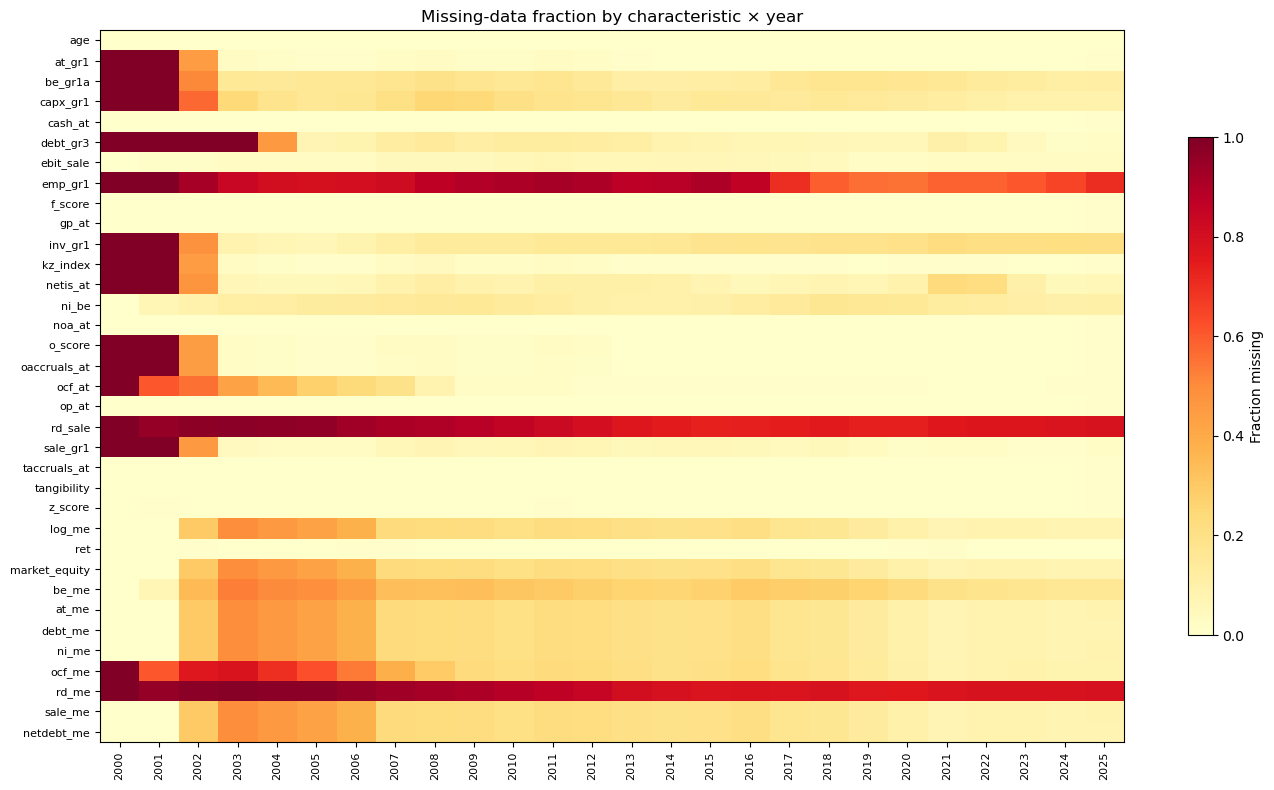

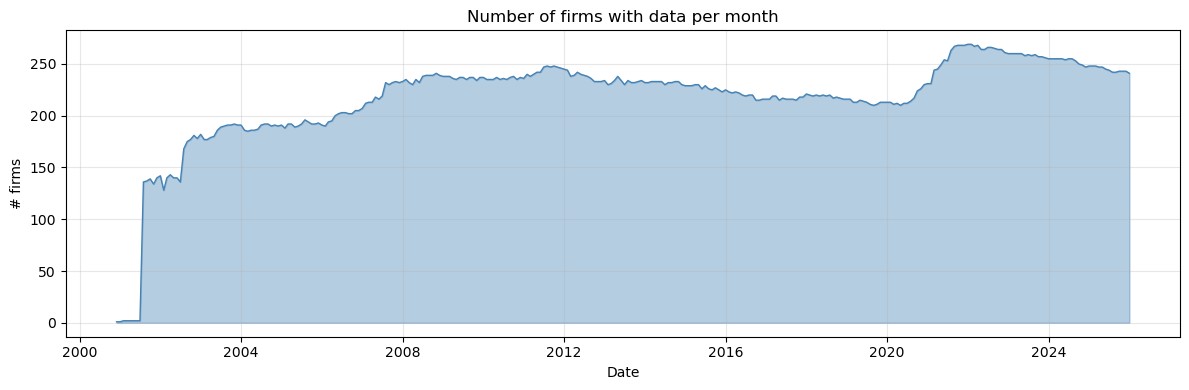

─────────────────────────────────────────────────────────────────
  SUMMARY STATISTICS
─────────────────────────────────────────────────────────────────
  Characteristic summary statistics

  Characteristic summary statistics



,count,mean,std,1%,5%,25%,50%,75%,95%,99%
age,"65,554.000",10.050,6.433,0.000,1.000,5.000,9.000,15.000,22.000,24.000
at_gr1,"63,335.000",384.040,"20,505.205",-0.564,-0.194,-0.008,0.075,0.198,0.773,2.938
be_gr1a,"54,556.000",1.713,79.935,-0.741,-0.341,-0.019,0.068,0.193,1.441,6.705
capx_gr1,"53,763.000",1.789,37.251,-0.958,-0.760,-0.276,0.095,0.577,3.024,15.202
cash_at,"65,531.000",<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
debt_gr3,"54,757.000",10.377,244.526,-1.000,-0.720,-0.086,0.368,1.138,7.224,63.478
ebit_sale,"62,988.000",-1.550,29.294,-11.805,-0.523,0.028,0.097,0.175,0.378,0.673
emp_gr1,"15,058.000",0.068,0.361,-0.445,-0.226,-0.036,0.019,0.096,0.432,1.571
f_score,"65,531.000",5.009,1.876,1.000,2.000,4.000,5.000,6.000,8.000,9.000
gp_at,"65,531.000",<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [32]:


# ═══════════════════════════════════════════════════════════════════════
# PANEL DIAGNOSTICS
# ═══════════════════════════════════════════════════════════════════════

# ── 1. Basic dimensions ─────────────────────────────────────────────
print("=" * 65)
print("  PANEL OVERVIEW")
print("=" * 65)
print(f"  Shape               : {panel.shape[0]:,} rows  ×  {panel.shape[1]} columns")
print(f"  Unique ISINs        : {panel['isin'].nunique():,}")
print(f"  Unique gvkeys       : {panel['gvkey'].nunique():,}")
print(f"  Date range          : {panel['date'].min().strftime('%Y-%m-%d')}  →  {panel['date'].max().strftime('%Y-%m-%d')}")
print(f"  Unique months       : {panel['date'].nunique()}")
print(f"  Avg obs per firm    : {panel.groupby('isin').size().mean():.1f}")
print(f"  Median obs per firm : {panel.groupby('isin').size().median():.0f}")
print()

# ── 2. Variable inventory ──────────────────────────────────────────
char_acct = [
    "age", "at_gr1", "be_gr1a", "capx_gr1", "cash_at", "debt_gr3",
    "ebit_sale", "emp_gr1", "f_score", "gp_at", "inv_gr1", "kz_index",
    "netis_at", "ni_be", "noa_at", "o_score", "oaccruals_at", "ocf_at",
    "op_at", "rd_sale", "sale_gr1", "taccruals_at", "tangibility", "z_score",
]
char_mkt = [
    "log_me", "ret", "market_equity",
    "be_me", "at_me", "debt_me", "ni_me", "ocf_me", "rd_me",
    "sale_me", "netdebt_me",
]
all_chars = char_acct + char_mkt
present = [c for c in all_chars if c in panel.columns]

print(f"  Accounting chars    : {sum(1 for c in char_acct if c in panel.columns)} / {len(char_acct)}")
print(f"  Market-scaled chars : {sum(1 for c in char_mkt  if c in panel.columns)} / {len(char_mkt)}")
print(f"  Total chars present : {len(present)}")
print()

# ── 3. Missing-data table ──────────────────────────────────────────
miss = (
    panel[present]
    .isna()
    .mean()
    .mul(100)
    .sort_values(ascending=False)
    .rename("missing_%")
    .to_frame()
)
miss["non_null"] = panel[present].notna().sum().reindex(miss.index)
miss["dtype"]    = panel[present].dtypes.reindex(miss.index).astype(str)

print("─" * 65)
print("  MISSING DATA BY CHARACTERISTIC")
print("─" * 65)
for name, row in miss.iterrows():
    bar = "█" * int(row["missing_%"] / 2.5)  # 1 block ≈ 2.5%
    print(f"  {name:<20s}  {row['missing_%']:5.1f}%  {row['non_null']:>8,.0f} obs  {bar}")
print()

# ── 4. Missing-data heatmap (by year) ─────────────────────────────
panel["year"] = panel["date"].dt.year
miss_by_year = (
    panel.groupby("year")[present]
    .apply(lambda g: g.isna().mean())
    .T
)

fig, ax = plt.subplots(figsize=(14, 8))
im = ax.imshow(miss_by_year.values, aspect="auto", cmap="YlOrRd", vmin=0, vmax=1)
ax.set_yticks(range(len(miss_by_year.index)))
ax.set_yticklabels(miss_by_year.index, fontsize=8)
ax.set_xticks(range(len(miss_by_year.columns)))
ax.set_xticklabels(miss_by_year.columns, rotation=90, fontsize=8)
ax.set_title("Missing-data fraction by characteristic × year", fontsize=12)
fig.colorbar(im, ax=ax, label="Fraction missing", shrink=0.7)
plt.tight_layout()
plt.show()

# ── 5. Firm coverage over time ────────────────────────────────────
firms_per_month = panel.groupby("date")["isin"].nunique()

fig, ax = plt.subplots(figsize=(12, 4))
ax.fill_between(firms_per_month.index, firms_per_month.values, alpha=0.4, color="steelblue")
ax.plot(firms_per_month.index, firms_per_month.values, color="steelblue", lw=1)
ax.set_title("Number of firms with data per month")
ax.set_xlabel("Date")
ax.set_ylabel("# firms")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ── 6. Summary statistics for all characteristics ─────────────────
print("─" * 65)
print("  SUMMARY STATISTICS")
print("─" * 65)
summary = panel[present].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]).T
summary = summary[["count", "mean", "std", "1%", "5%", "25%", "50%", "75%", "95%", "99%"]]
print("  Characteristic summary statistics")
print()
with pd.option_context("display.float_format", "{:,.3f}".format, "display.max_rows", 50):
    display(summary)

# Clean up temp column
panel.drop(columns=["year"], inplace=True, errors="ignore")

In [4]:
# ═══════════════════════════════════════════════════════════════════════
# DROP HIGH-MISSING CHARACTERISTICS & SAVE FINAL CSV
# ═══════════════════════════════════════════════════════════════════════

from pathlib import Path

# Columns with too many missing values (>50% missing)
DROP_COLS = ["rd_me", "rd_sale", "emp_gr1"]

print("Dropping columns with excessive missing data:")
for col in DROP_COLS:
    pct = panel[col].isna().mean() * 100
    print(f"  {col:<15s}  {pct:.1f}% missing  ✗ dropped")

panel_clean = panel.drop(columns=DROP_COLS)
print(f"\nPanel after drop: {panel_clean.shape[0]:,} rows × {panel_clean.shape[1]} columns")

# Save to the same folder as this notebook
out_path = Path("/Users/juliaborges/Library/Mobile Documents/com~apple~CloudDocs/MMS/Research/GitHub/Systematic_Brazil/brazil_characteristics.csv")
panel_clean.to_csv(out_path, index=False)
print(f"Saved → {out_path}")
print(f"  File size: {out_path.stat().st_size / 1e6:.1f} MB")

Dropping columns with excessive missing data:
  rd_me            84.5% missing  ✗ dropped
  rd_sale          82.1% missing  ✗ dropped
  emp_gr1          77.0% missing  ✗ dropped

Panel after drop: 65,554 rows × 55 columns

Panel after drop: 65,554 rows × 55 columns
Saved → /Users/juliaborges/Library/Mobile Documents/com~apple~CloudDocs/MMS/Research/GitHub/Systematic_Brazil/brazil_characteristics.csv
  File size: 50.4 MB
Saved → /Users/juliaborges/Library/Mobile Documents/com~apple~CloudDocs/MMS/Research/GitHub/Systematic_Brazil/brazil_characteristics.csv
  File size: 50.4 MB
